<a href="https://colab.research.google.com/github/motykatomasz/DeepImagePrior/blob/master/DeepImagePrior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Reproducing Deep Image Prior paper
=====================

In this notebook we reproduce Table 1 in Deep Image Prior paper. Although the authors of the paper made the code available online, this is out approach to independently reproduce thair results. 
We developed the code in Jupyter notebook and it is compatible with Google Colab platform to be used with GPU.


## What is Deep Image Prior

In the paper, the authors argue that a great
deal of image statistics are captured by the structure of
a convolutional image generator independent of learning.
What it means is that we can train the generator netowrk on a single degraded image, instead of large dataset of example images,
to reconstruct the image. In this scheme, the network weights serve
as a parametrization of the restored image.


## How does it work?

Lets assume that our image x is under following process:

$ x \Rightarrow Degradation \Rightarrow  \hat{x} \Rightarrow  Restoration \Rightarrow x^{*} $

Our goal is to find $ x^{*}$.
We can do that by finding the MAP estimate of our posterior distribution of clean images:

\begin{equation}
MAP: x^{*} = argmax_{x} p(x|\hat{x})
\end{equation}

As it is usually the case, obtaining posterior distribution $p(x|\hat{x})$ is intractable. We can rewrite the equation using Bayes theorem:

\begin{equation}
p(x|\hat{x}) = \frac{p(\hat{x}|x)p(x)}{p(\hat{x})} \sim p(\hat{x}|x)p(x)
\end{equation}


to be continued...


In [10]:
!pip install torch torchvision Pillow
!apt-get update
!apt-get install subversion
!svn checkout https://github.com/DmitryUlyanov/deep-image-prior/trunk/data

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
subvers

In [14]:
try:
    import models
except ImportError:
    from getpass import getpass
    branch = input('branch (master): ')
    branch = 'master' if branch == '' else branch
    !pip install git+https://{input('git user: ')}:{getpass('git password: ')}@github.com/motykatomasz/DeepImagePrior@{branch}

In [14]:
ls data/

denoising/          imagenet1000_clsid_to_human.txt  sr/
feature_inversion/  inpainting/                      teaser_compiled.jpg
flash_no_flash/     restoration/


In [16]:
import torch
from PIL import Image
from numpy import asarray
from models.unet import UNet
import torch.optim as optim
from models.utils import z, imshow, image_to_tensor, tensor_to_image
from configs import inpaintingSettings

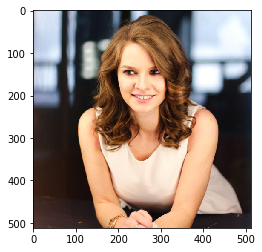

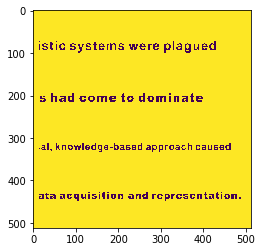

Step :0, Loss: 415431.1875


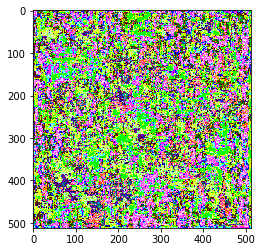

OUTPUT IMAGE
Step :1, Loss: 295218.40625
Step :2, Loss: 236276.375
Step :3, Loss: 192688.15625
Step :4, Loss: 184897.40625
Step :5, Loss: 206416.828125
Step :6, Loss: 221951.6875
Step :7, Loss: 216420.40625
Step :8, Loss: 210196.609375
Step :9, Loss: 199180.0625
Step :10, Loss: 197374.8125
Step :11, Loss: 183110.6875
Step :12, Loss: 181160.375
Step :13, Loss: 181374.265625
Step :14, Loss: 167208.6875
Step :15, Loss: 162786.046875
Step :16, Loss: 168315.6875
Step :17, Loss: 185008.21875
Step :18, Loss: 210095.84375
Step :19, Loss: 238379.09375
Step :20, Loss: 268053.71875
Step :21, Loss: 297314.8125
Step :22, Loss: 302307.5
Step :23, Loss: 303686.375
Step :24, Loss: 289441.9375
Step :25, Loss: 291016.90625
Step :26, Loss: 289467.0625
Step :27, Loss: 292742.25
Step :28, Loss: 298213.125
Step :29, Loss: 294295.125
Step :30, Loss: 276534.09375
Step :31, Loss: 265312.25
Step :32, Loss: 251248.46875
Step :33, Loss: 232434.5625
Step :34, Loss: 217404.625


KeyboardInterrupt: 

In [19]:
img_path = "data/kate.png"
img = Image.open(img_path)
imshow(asarray(img))

mask_path = "data/kate_mask.png"
mask = Image.open(mask_path)
imshow(asarray(mask))

x = image_to_tensor(img)
mask = image_to_tensor(mask)

net = UNet(inpaintingSettings)

if torch.cuda.is_available():
    net = net.cuda()

mse = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.1)

# Num of iters for training
num_iters = 5000

# Num of iters when to save image
save_frequency = 250

#Since we only have 1 image to train on, we set zero_gradienet once at the beginning
optimizer.zero_grad()

z0 = z(shape=(img.height, img.width), channels=32)

for i in range(num_iters):
    output = net(z0)

    # Optimizer
    loss = torch.sum(torch.mul((output - x), mask)**2)
    # loss = mse(output * mask, x * mask)
    loss.backward()
    optimizer.step()

    print('Step :{}, Loss: {}'.format(i, loss.data.cpu()))

    
    if i % save_frequency == 0:
        out_img = tensor_to_image(output)
        imshow(asarray(out_img))
        print('OUTPUT IMAGE')